In [1]:
import captum 
import torch
import optuna
import cv2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

from torchvision import transforms

from captum.attr import visualization as viz

from sklearn.model_selection import train_test_split

from optuna_funcs import load_data, objective
from cnn import CNN, ResNet, CNNTransferLearning

Loading data.

In [2]:
baseline = torch.load('../best_models/milho_baseline.pth', map_location='cpu', weights_only=True)
plantvillage_da = torch.load('../best_models/milho_plantvillage_domain_adaptation.pth', map_location='cpu', weights_only=True)
plantvillage_ft = torch.load('../best_models/milho_plantvillage_fine_tuning.pth', map_location='cpu', weights_only=True)
resnet_da = torch.load('../best_models/milho_resnet_domain_adaptation.pth', map_location='cpu', weights_only=True)
resnet_ft = torch.load('../best_models/milho_resnet_fine_tuning.pth', map_location='cpu', weights_only=True)

In [3]:
data = torch.load('data_milho.pth', map_location='cpu', weights_only=True)

x_train, y_train = data['x_train'], data['y_train']
x_test, y_test = data['x_test'], data['y_test']
names_train, names_test = data['names_train'], data['names_test']

test_transforms = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

x_test = test_transforms(x_test)

Loading and instantiating models.

In [4]:
n_classes = 5

# Baseline
STUDY_NAME = 'milho_baseline'
study = optuna.load_study(study_name=STUDY_NAME, storage=f'sqlite:///../hp_tuning/{STUDY_NAME}.db')

df = pd.read_csv(f'../cross_validation/{STUDY_NAME}.csv')
columns = df.filter(like="Cross_Val")
df['Mean'] = columns.mean(axis=1)
df = df.drop(columns="Unnamed: 0")
df = df.sort_values(by=["Mean"], ascending=False)
df = df.reset_index(drop=True)

best_trial_num = df["Number"][0]
best_trial = study.get_trials()[best_trial_num]
kfold_acc = [df[f'Cross_Val_{i}'][0].item() for i in range(10)]

model_baseline = objective(
    best_trial,
    None,
    None,
    device='cpu',
    instantiate=True
)

model_baseline.load_state_dict(baseline['model'])

# PlantVillage-DA
STUDY_NAME = 'plantvillage'
study = optuna.load_study(study_name=STUDY_NAME, storage=f'sqlite:///../../plantvillage/hp_tuning/{STUDY_NAME}.db')

df = pd.read_csv(f'../../plantvillage/cross_validation/{STUDY_NAME}.csv')
columns = df.filter(like="Cross_Val")
df['Mean'] = columns.mean(axis=1)
df = df.drop(columns="Unnamed: 0")
df = df.sort_values(by=["Mean"], ascending=False)
df = df.reset_index(drop=True)

best_trial_num = df["Number"][0]
best_trial = study.get_trials()[best_trial_num]

model_plantvillage_da = CNNTransferLearning(best_trial, n_classes=n_classes, device='cpu', fine_tuning=True)
model_plantvillage_da.load_state_dict(plantvillage_da['model'])

# PlantVillage-FT
model_plantvillage_ft = CNNTransferLearning(best_trial, n_classes=n_classes, device='cpu', fine_tuning=True)
model_plantvillage_ft.load_state_dict(plantvillage_ft['model'])

# ResNet50-DA
model_resnet_da = ResNet(n_classes=n_classes, fine_tuning=True)
model_resnet_da.load_state_dict(resnet_da['model'])

# ResNet50-FT
model_resnet_ft = ResNet(n_classes=n_classes, fine_tuning=True)
model_resnet_ft.load_state_dict(resnet_ft['model'])

<All keys matched successfully>

# GradCam

In [5]:
def deprocess_image(tensor):
    img_np = tensor.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    img_np = (img_np - np.min(img_np)) / (np.max(img_np) - np.min(img_np))
    img_np = np.uint8(255 * img_np)
    return img_np

## Baseline

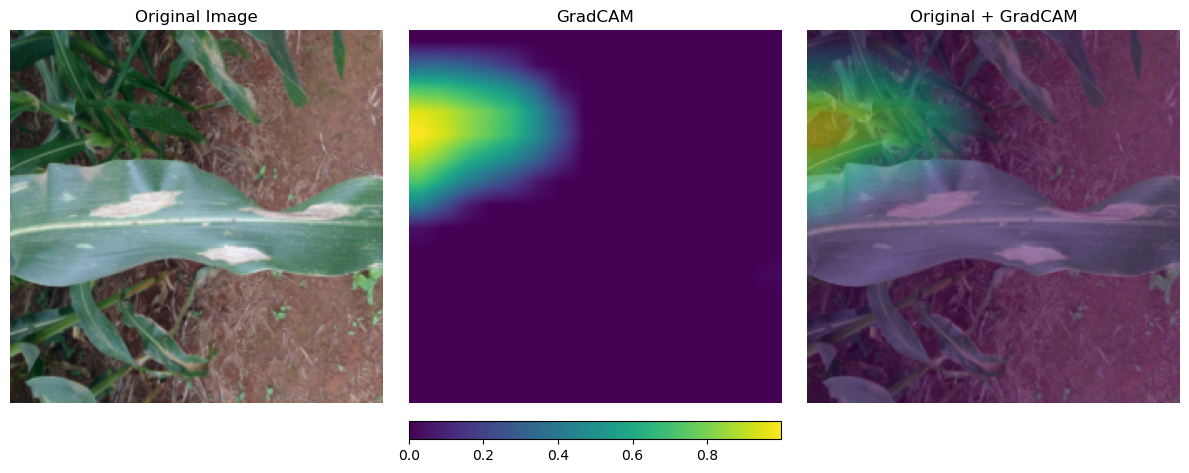

In [6]:
gradcam = captum.attr.LayerGradCam(model_baseline, model_baseline.conv[12])
out = gradcam.attribute(x_test, target=y_test)

idx = 4

heatmap = out[idx].squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)  
heatmap_resized = cv2.resize(heatmap, (224, 224))

heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

original_img = deprocess_image(x_test[idx])
superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

im = axes[1].imshow(heatmap_resized, cmap="viridis")
axes[1].set_title("GradCAM")
axes[1].axis('off')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, orientation="horizontal")

axes[2].imshow(superimposed_img)
axes[2].set_title("Original + GradCAM")
axes[2].axis('off')

plt.tight_layout()
plt.show()

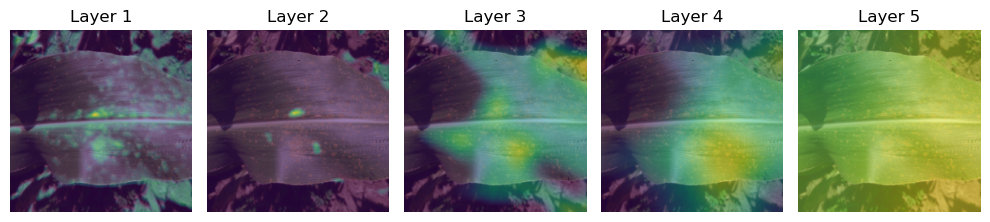

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(10, 10))
axes = axes.flatten() 

idx = 5 

for i in range(5):
    if i == 0:
        gradcam = captum.attr.LayerGradCam(model_baseline, model_baseline.conv[0])
        layer_name = "Layer 1"
    elif i == 1:
        gradcam = captum.attr.LayerGradCam(model_baseline, model_baseline.conv[4])
        layer_name = "Layer 2"
    elif i == 2:
        gradcam = captum.attr.LayerGradCam(model_baseline, model_baseline.conv[8])
        layer_name = "Layer 3"
    elif i == 3:
        gradcam = captum.attr.LayerGradCam(model_baseline, model_baseline.conv[12])
        layer_name = "Layer 4"
    elif i == 4:
        gradcam = captum.attr.LayerGradCam(model_baseline, model_baseline.conv[16])
        layer_name = "Layer 5"
    
    out = gradcam.attribute(x_test, target=y_test)
    
    heatmap = out[idx].squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
    heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)
    
    original_img = deprocess_image(x_test[idx])
    superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)
    
    axes[i].imshow(superimposed_img)
    axes[i].set_title(f"Layer {i+1}")
    axes[i].axis('off')
    
plt.tight_layout()
plt.show()

## PlantVillage-FE

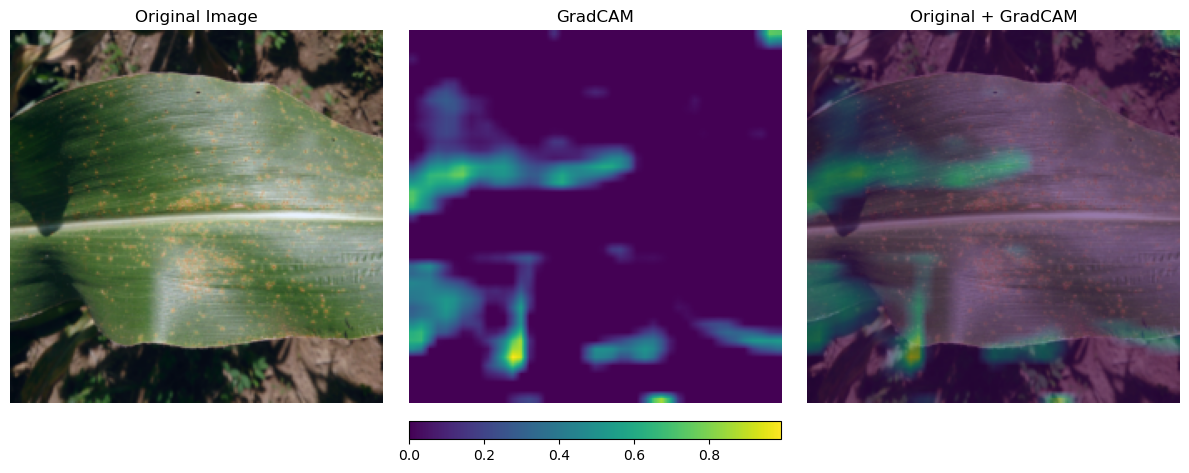

In [8]:
gradcam = captum.attr.LayerGradCam(model_plantvillage_da, model_plantvillage_da.cnn.conv[6])
out = gradcam.attribute(x_test, target=y_test)

idx = 5

heatmap = out[idx].squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)  
heatmap_resized = cv2.resize(heatmap, (224, 224))

heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

original_img = deprocess_image(x_test[idx])
superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

im = axes[1].imshow(heatmap_resized, cmap="viridis")
axes[1].set_title("GradCAM")
axes[1].axis('off')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, orientation="horizontal")

axes[2].imshow(superimposed_img)
axes[2].set_title("Original + GradCAM")
axes[2].axis('off')

plt.tight_layout()
plt.show()

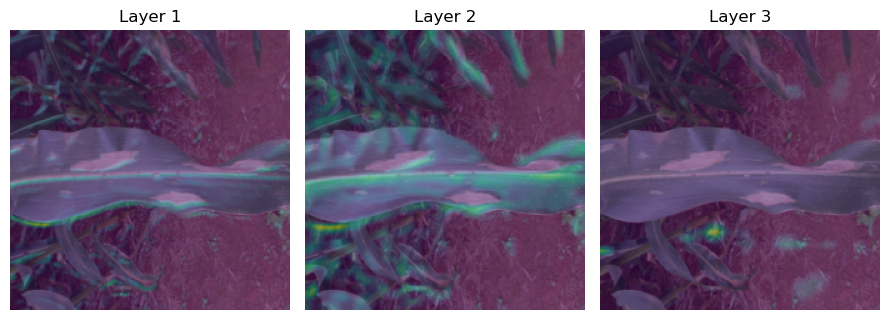

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(9, 10))
axes = axes.flatten() 

idx = 4

for i in range(3):
    if i == 0:
        gradcam = captum.attr.LayerGradCam(model_plantvillage_da, model_plantvillage_da.cnn.conv[0])
        layer_name = "Layer 1"
    elif i == 1:
        gradcam = captum.attr.LayerGradCam(model_plantvillage_da, model_plantvillage_da.cnn.conv[3])
        layer_name = "Layer 2"
    elif i == 2:
        gradcam = captum.attr.LayerGradCam(model_plantvillage_da, model_plantvillage_da.cnn.conv[6])
        layer_name = "Layer 3"
    
    out = gradcam.attribute(x_test, target=y_test, relu_attributions=True)
    
    heatmap = out[idx].squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
    heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)
    
    original_img = deprocess_image(x_test[idx])
    superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)
    
    axes[i].imshow(superimposed_img)
    axes[i].set_title(f"Layer {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## PlantVillage-FT

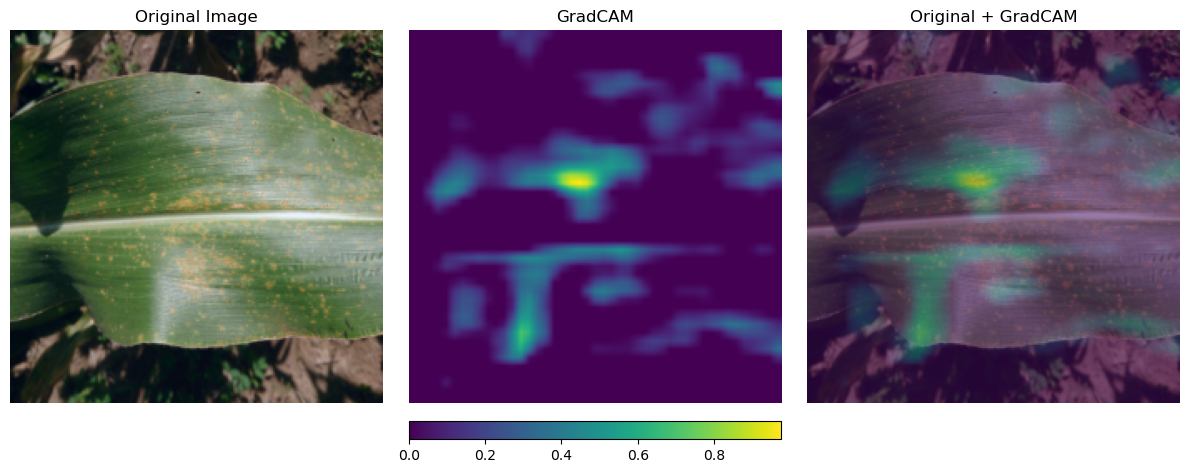

In [10]:
gradcam = captum.attr.LayerGradCam(model_plantvillage_ft, model_plantvillage_ft.cnn.conv[6])
out = gradcam.attribute(x_test, target=y_test)

idx = 5

heatmap = out[idx].squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)  
heatmap_resized = cv2.resize(heatmap, (224, 224))

heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

original_img = deprocess_image(x_test[idx])
superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

im = axes[1].imshow(heatmap_resized, cmap="viridis")
axes[1].set_title("GradCAM")
axes[1].axis('off')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, orientation="horizontal")

axes[2].imshow(superimposed_img)
axes[2].set_title("Original + GradCAM")
axes[2].axis('off')

plt.tight_layout()
plt.show()

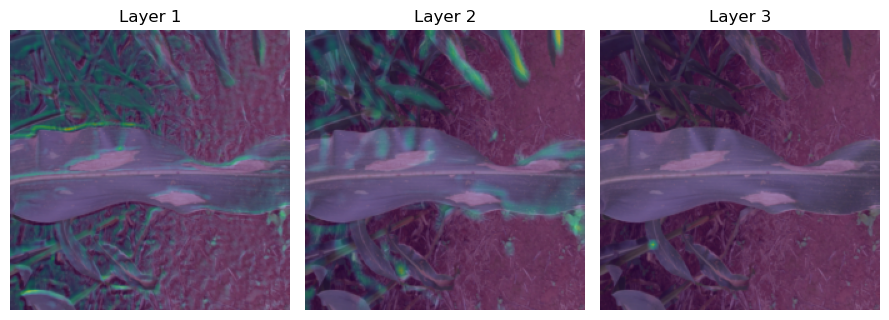

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(9, 10))
axes = axes.flatten() 

idx = 4

for i in range(3):
    if i == 0:
        gradcam = captum.attr.LayerGradCam(model_plantvillage_ft, model_plantvillage_ft.cnn.conv[0])
        layer_name = "Layer 1"
    elif i == 1:
        gradcam = captum.attr.LayerGradCam(model_plantvillage_ft, model_plantvillage_ft.cnn.conv[3])
        layer_name = "Layer 2"
    elif i == 2:
        gradcam = captum.attr.LayerGradCam(model_plantvillage_ft, model_plantvillage_ft.cnn.conv[6])
        layer_name = "Layer 3"
    
    out = gradcam.attribute(x_test, target=y_test, relu_attributions=True)
    
    heatmap = out[idx].squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
    heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)
    
    original_img = deprocess_image(x_test[idx])
    superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)
    
    axes[i].imshow(superimposed_img)
    axes[i].set_title(f"Layer {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## ResNet50-FE

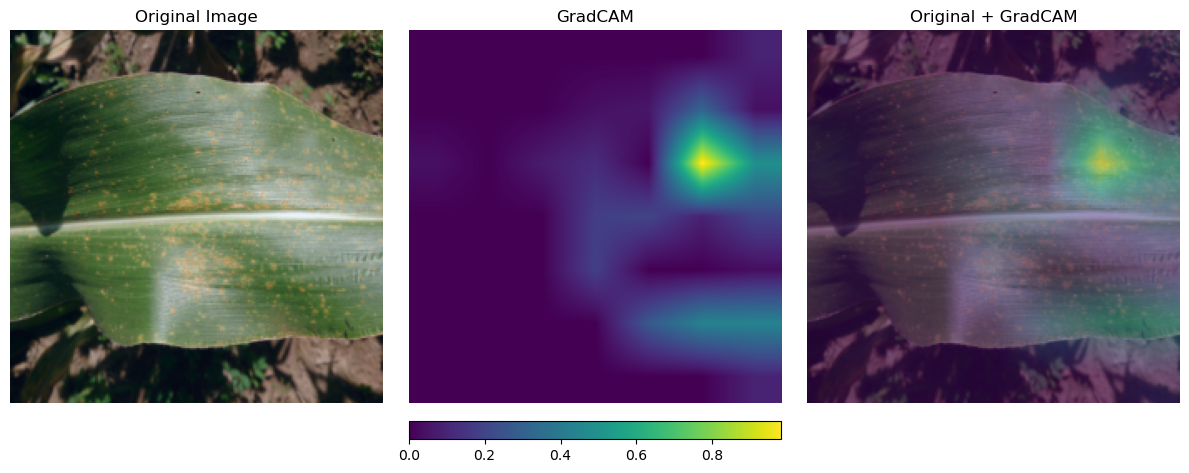

In [12]:
gradcam = captum.attr.LayerGradCam(model_resnet_da, model_resnet_da.resnet.layer4)
out = gradcam.attribute(x_test, target=y_test)

idx = 5

heatmap = out[idx].squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)  
heatmap_resized = cv2.resize(heatmap, (224, 224))

heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

original_img = deprocess_image(x_test[idx])
superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

im = axes[1].imshow(heatmap_resized, cmap="viridis")
axes[1].set_title("GradCAM")
axes[1].axis('off')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, orientation="horizontal")

axes[2].imshow(superimposed_img)
axes[2].set_title("Original + GradCAM")
axes[2].axis('off')

plt.tight_layout()
plt.show()

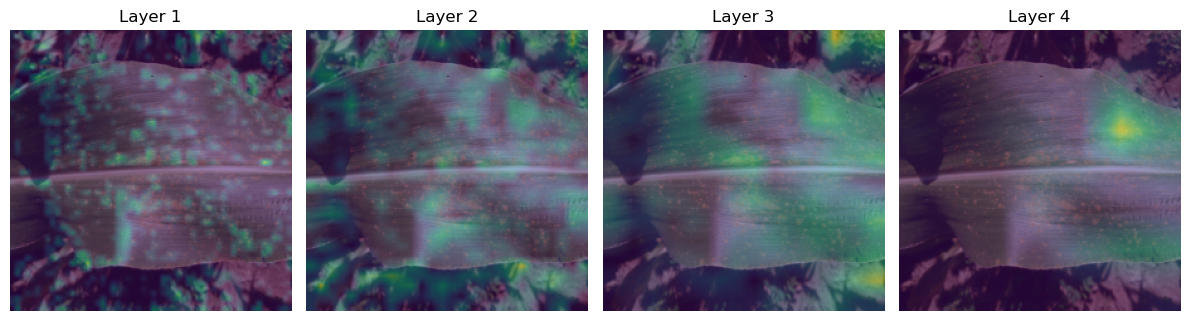

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(12, 10))
axes = axes.flatten() 

idx = 5 

for i in range(4):
    if i == 0:
        gradcam = captum.attr.LayerGradCam(model_resnet_da, model_resnet_da.resnet.layer1)
        layer_name = "Layer 1"
    elif i == 1:
        gradcam = captum.attr.LayerGradCam(model_resnet_da, model_resnet_da.resnet.layer2)
        layer_name = "Layer 2"
    elif i == 2:
        gradcam = captum.attr.LayerGradCam(model_resnet_da, model_resnet_da.resnet.layer3)
        layer_name = "Layer 3"
    elif i == 3:
        gradcam = captum.attr.LayerGradCam(model_resnet_da, model_resnet_da.resnet.layer4)
        layer_name = "Layer 4"
    
    out = gradcam.attribute(x_test, target=y_test, relu_attributions=True)
    
    heatmap = out[idx].squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
    heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)
    
    original_img = deprocess_image(x_test[idx])
    superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)
    
    axes[i].imshow(superimposed_img)
    axes[i].set_title(f"Layer {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## ResNet50-FT

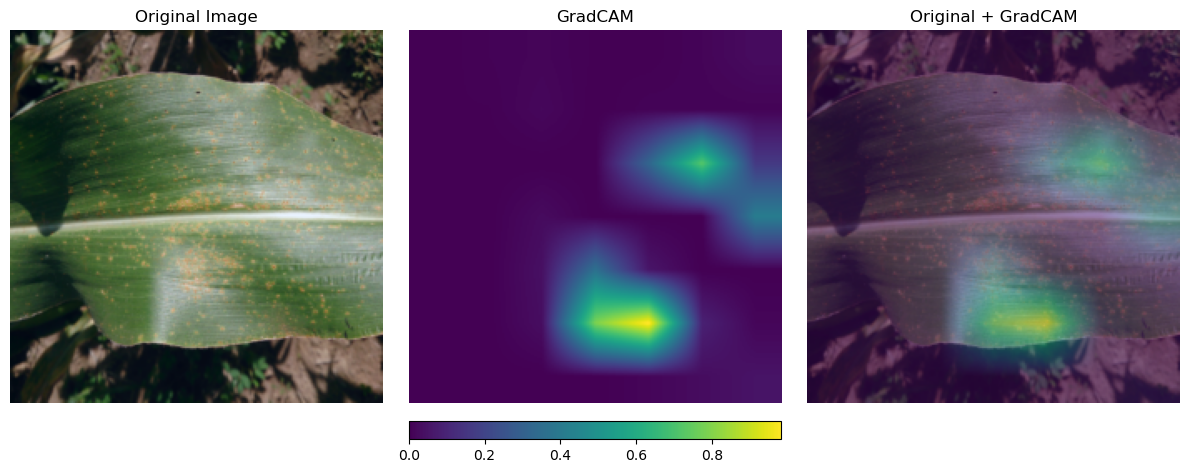

In [14]:
gradcam = captum.attr.LayerGradCam(model_resnet_ft, model_resnet_ft.resnet.layer4)
out = gradcam.attribute(x_test, target=y_test)

idx = 5

heatmap = out[idx].squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)  
heatmap_resized = cv2.resize(heatmap, (224, 224))

heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

original_img = deprocess_image(x_test[idx])
superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

axes[0].imshow(original_img)
axes[0].set_title("Original Image")
axes[0].axis('off')

im = axes[1].imshow(heatmap_resized, cmap="viridis")
axes[1].set_title("GradCAM")
axes[1].axis('off')
fig.colorbar(im, ax=axes[1], fraction=0.046, pad=0.04, orientation="horizontal")

axes[2].imshow(superimposed_img)
axes[2].set_title("Original + GradCAM")
axes[2].axis('off')

plt.tight_layout()
plt.show()

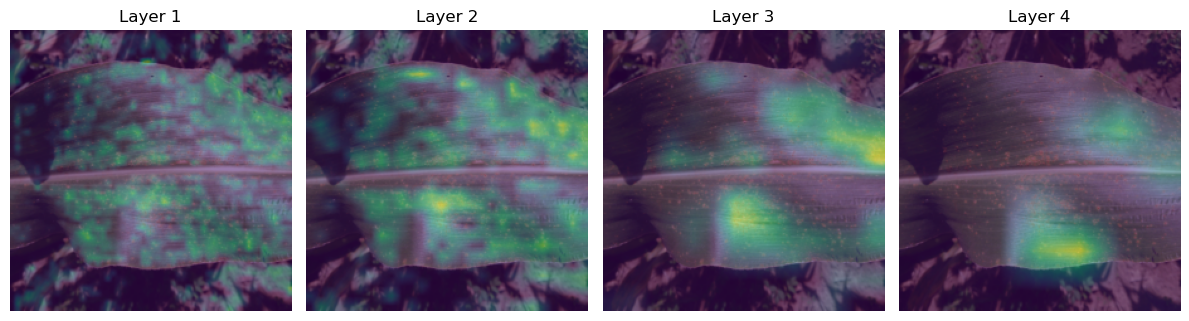

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(12, 10))
axes = axes.flatten() 

idx = 5 

for i in range(4):
    if i == 0:
        gradcam = captum.attr.LayerGradCam(model_resnet_ft, model_resnet_ft.resnet.layer1)
        layer_name = "Layer 1"
    elif i == 1:
        gradcam = captum.attr.LayerGradCam(model_resnet_ft, model_resnet_ft.resnet.layer2)
        layer_name = "Layer 2"
    elif i == 2:
        gradcam = captum.attr.LayerGradCam(model_resnet_ft, model_resnet_ft.resnet.layer3)
        layer_name = "Layer 3"
    elif i == 3:
        gradcam = captum.attr.LayerGradCam(model_resnet_ft, model_resnet_ft.resnet.layer4)
        layer_name = "Layer 4"
    
    out = gradcam.attribute(x_test, target=y_test, relu_attributions=True)
    
    heatmap = out[idx].squeeze().detach().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)  
    heatmap_resized = cv2.resize(heatmap, (224, 224))
    
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
    heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)
    
    original_img = deprocess_image(x_test[idx])
    superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)
    
    axes[i].imshow(superimposed_img)
    axes[i].set_title(f"Layer {i+1}")
    axes[i].axis('off')

plt.tight_layout()
plt.show()

## Comparison

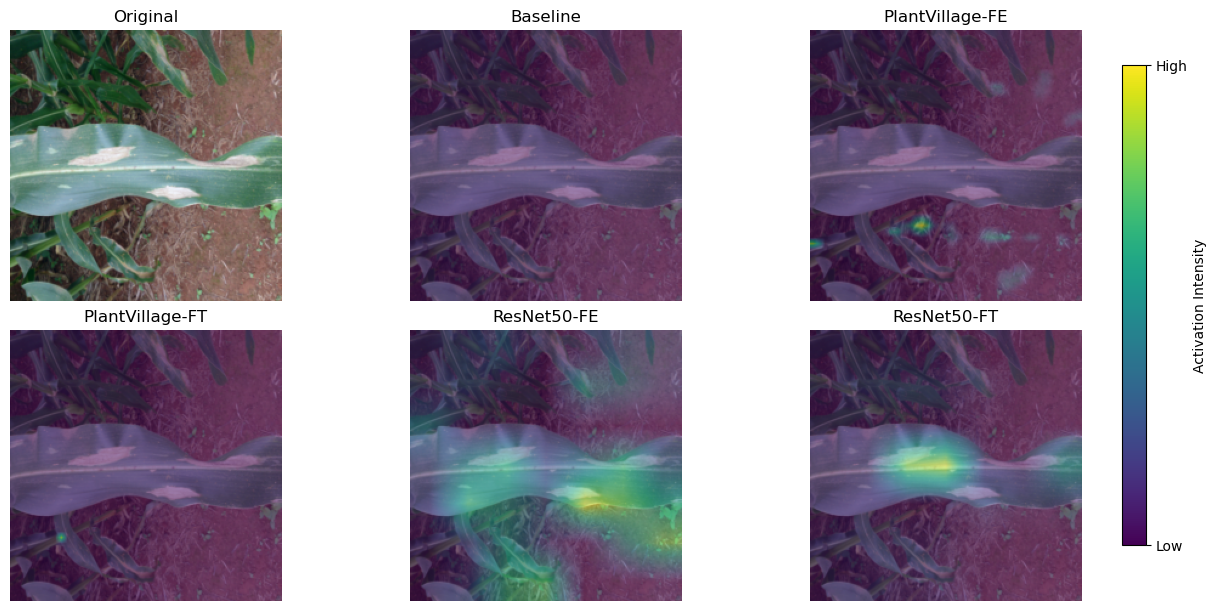

In [16]:
idx = 4

fig, axes = plt.subplots(2, 3, figsize=(12, 6), constrained_layout=True)

original_img = deprocess_image(x_test[idx])

axes[0, 0].imshow(original_img)
axes[0, 0].set_title("Original")
axes[0, 0].axis('off')

gradcam = captum.attr.LayerGradCam(model_baseline, model_baseline.conv[16])
out = gradcam.attribute(x_test, target=y_test)

heatmap = out[idx].squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap_resized = cv2.resize(heatmap, (224, 224))

heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)

axes[0, 1].imshow(superimposed_img)
axes[0, 1].set_title("Baseline")
axes[0, 1].axis('off')

gradcam = captum.attr.LayerGradCam(model_plantvillage_da, model_plantvillage_da.cnn.conv[6])
out = gradcam.attribute(x_test, target=y_test)

heatmap = out[idx].squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)  
heatmap_resized = cv2.resize(heatmap, (224, 224))

heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

original_img = deprocess_image(x_test[idx])
superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)

axes[0, 2].imshow(superimposed_img)
axes[0, 2].set_title("PlantVillage-FE")
axes[0, 2].axis('off')

gradcam = captum.attr.LayerGradCam(model_plantvillage_ft, model_plantvillage_ft.cnn.conv[6])
out = gradcam.attribute(x_test, target=y_test)

heatmap = out[idx].squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)  
heatmap_resized = cv2.resize(heatmap, (224, 224))

heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

original_img = deprocess_image(x_test[idx])
superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)

axes[1, 0].imshow(superimposed_img)
axes[1, 0].set_title("PlantVillage-FT")
axes[1, 0].axis('off')

gradcam = captum.attr.LayerGradCam(model_resnet_da, model_resnet_da.resnet.layer4)
out = gradcam.attribute(x_test, target=y_test)

heatmap = out[idx].squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)  
heatmap_resized = cv2.resize(heatmap, (224, 224))

heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)

axes[1, 1].imshow(superimposed_img)
axes[1, 1].set_title("ResNet50-FE")
axes[1, 1].axis('off')

gradcam = captum.attr.LayerGradCam(model_resnet_ft, model_resnet_ft.resnet.layer4)
out = gradcam.attribute(x_test, target=y_test)

heatmap = out[idx].squeeze().detach().cpu().numpy()
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)  
heatmap_resized = cv2.resize(heatmap, (224, 224))

heatmap_uint8 = np.uint8(255 * heatmap_resized)
heatmap_jet = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_VIRIDIS)
heatmap_rgb = cv2.cvtColor(heatmap_jet, cv2.COLOR_BGR2RGB)

superimposed_img = cv2.addWeighted(heatmap_rgb, 0.5, original_img, 0.5, 0)

axes[1, 2].imshow(superimposed_img)
axes[1, 2].set_title("ResNet50-FT")
axes[1, 2].axis('off')

cax = fig.add_axes([0.98, 0.1, 0.02, 0.8])  

cbar = fig.colorbar(
    plt.cm.ScalarMappable(cmap="viridis", norm=plt.Normalize(vmin=0, vmax=1)),
    cax=cax,
    orientation="vertical"
)
cbar.set_ticks([0, 1])
cbar.set_ticklabels(["Low", "High"])
cbar.set_label("Activation Intensity")

plt.show()